# Import packages and data

In [2]:
# Standard
import pandas as pd
import numpy as np
import random
import os


# Plots and images
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
pd.set_option('display.max_columns', None)

# Silence TF
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Setting random seeds
random.seed(0)
np.random.seed(0)

2023-12-10 14:00:07.634737: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Local Data Import

In [3]:
X_train = pd.read_csv('data/X_train.csv')
Y_train = pd.read_csv('data/Y_train.csv')
X_val = pd.read_csv('data/X_val.csv')
Y_val = pd.read_csv('data/Y_val.csv')
X_test = pd.read_csv('data/X_test.csv')
Y_test = pd.read_csv('data/Y_test.csv')

In [6]:
# Drop unnamed column from all datasets
X_train.drop(columns=['Unnamed: 0'], inplace=True)
Y_train.drop(columns=['Unnamed: 0'], inplace=True)
X_val.drop(columns=['Unnamed: 0'], inplace=True)
Y_val.drop(columns=['Unnamed: 0'], inplace=True)
X_test.drop(columns=['Unnamed: 0'], inplace=True)
Y_test.drop(columns=['Unnamed: 0'], inplace=True)

# EDA For Tree Based Algorithms

In [7]:
# Joining in Team Difficulty Index to refactor the player team name
# Importing difficulty data
difficulty_data = pd.read_csv('data/team_difficulty_ind.csv')

# Merging in the difficulty data on home team name (due to limitations on home teams by season [i.e. some home teams in val do not exist in train due to prommotion/relegation])
X_train = X_train.merge(difficulty_data, how='left', left_on='player_team_name', right_on='team_name').drop(columns = ['team_name'])
X_val = X_val.merge(difficulty_data, how='left', left_on='player_team_name', right_on='team_name').drop(columns = ['team_name'])
X_test = X_test.merge(difficulty_data, how='left', left_on='player_team_name', right_on='team_name').drop(columns = ['team_name'])

# Renaming the home difficulty column
X_train.rename(columns={"FDI": "player_team_ind"}, inplace=True)
X_val.rename(columns={"FDI": "player_team_ind"}, inplace=True)
X_test.rename(columns={"FDI": "player_team_ind"}, inplace=True)

In [10]:
# Capture categorical variables
cat_columns = ['GW', 'player_team_ind', 'opp_diff_ind','position', 'was_home']

#dropping season, player_team_name, opp_team_name due to categorical encoding limitations (e.g. Season 2018/19 does not exist in Validation set)
dropped_columns = ['season', 'player_team_name', 'opp_team_name']

# Create dummy variables for all other categorical variables
X_train_encoded = pd.get_dummies(X_train, columns = cat_columns)
X_train_encoded.drop(columns=dropped_columns, inplace=True)

X_val_encoded = pd.get_dummies(X_val, columns = cat_columns)
X_val_encoded.drop(columns=dropped_columns, inplace=True)

X_test_encoded = pd.get_dummies(X_test, columns = cat_columns)
X_test_encoded.drop(columns=dropped_columns, inplace=True)

In [12]:
# Add a false GW7 due to her majesty's passing
X_test_encoded['GW_7'] = False
X_test_encoded = X_test_encoded[X_train_encoded.columns]

In [14]:
X_train_encoded

,assists_lag_1,bonus_lag_1,bps_lag_1,clean_sheets_lag_1,creativity_lag_1,goals_conceded_lag_1,goals_scored_lag_1,ict_index_lag_1,influence_lag_1,minutes_lag_1,own_goals_lag_1,penalties_missed_lag_1,penalties_saved_lag_1,red_cards_lag_1,saves_lag_1,selected_lag_1,player_team_score_lag_1,opp_team_score_lag_1,threat_lag_1,total_points_lag_1,value_lag_1,yellow_cards_lag_1,assists_lag_3,bonus_lag_3,bps_lag_3,clean_sheets_lag_3,creativity_lag_3,goals_conceded_lag_3,goals_scored_lag_3,ict_index_lag_3,influence_lag_3,minutes_lag_3,own_goals_lag_3,penalties_missed_lag_3,penalties_saved_lag_3,red_cards_lag_3,saves_lag_3,selected_lag_3,player_team_score_lag_3,opp_team_score_lag_3,threat_lag_3,total_points_lag_3,value_lag_3,yellow_cards_lag_3,assists_lag_5,bonus_lag_5,bps_lag_5,clean_sheets_lag_5,creativity_lag_5,goals_conceded_lag_5,goals_scored_lag_5,ict_index_lag_5,influence_lag_5,minutes_lag_5,own_goals_lag_5,penalties_missed_lag_5,penalties_saved_lag_5,red_cards_lag_5,saves_lag_5,selected_lag_5,player_team_score_lag_5,opp_team_score_lag_5,threat_lag_5,total_points_lag_5,value_lag_5,yellow_cards_lag_5,GW_1,GW_2,GW_3,GW_4,GW_5,GW_6,GW_7,GW_8,GW_9,GW_10,GW_11,GW_12,GW_13,GW_14,GW_15,GW_16,GW_17,GW_18,GW_19,GW_20,GW_21,GW_22,GW_23,GW_24,GW_25,GW_26,GW_27,GW_28,GW_29,GW_30,GW_31,GW_32,GW_33,GW_34,GW_35,GW_36,GW_37,GW_38,player_team_ind_1,player_team_ind_2,player_team_ind_3,player_team_ind_4,opp_diff_ind_1,opp_diff_ind_2,opp_diff_ind_3,opp_diff_ind_4,position_DEF,position_FWD,position_GK,position_MID,was_home_False,was_home_True
0,-0.184964,-0.215403,-0.606985,-0.337274,-0.437810,-0.508046,-0.188555,-0.562091,-0.555264,-0.785924,-0.038724,-0.029791,-0.025034,-0.044671,-0.150989,-0.406561,-1.049287,-1.053934,-0.391042,-0.532634,-3.367246,-0.231739,-0.286585,-0.332783,-0.750849,-0.495921,-0.548162,-0.684023,-0.279485,-0.684830,-0.704265,-0.872107,-0.063972,-0.049956,-0.04048,-0.075565,-0.171572,-0.408072,-1.599196,-1.619560,-0.494354,-0.694657,-3.370340,-0.364314,-0.333476,-0.387287,-0.800614,-0.566673,-0.586000,-0.754589,-0.316723,-0.727066,-0.756172,-0.907968,-0.079379,-0.061733,-0.048352,-0.093734,-0.177503,-0.409936,-1.808301,-1.899736,-0.529878,-0.752585,-3.373454,-0.430582,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,True,False,False,False,True,False
1,-0.184964,-0.215403,-0.606985,-0.337274,-0.437810,-0.508046,-0.188555,-0.562091,-0.555264,-0.785924,-0.038724,-0.029791,-0.025034,-0.044671,-0.150989,-0.158255,-1.049287,2.131566,-0.391042,-0.532634,0.335223,-0.231739,-0.286585,-0.332783,-0.750849,-0.495921,-0.548162,-0.684023,-0.279485,-0.684830,-0.704265,-0.872107,-0.063972,-0.049956,-0.04048,-0.075565,-0.171572,-0.156925,-1.599196,3.264136,-0.494354,-0.694657,0.332269,-0.364314,-0.333476,-0.387287,-0.800614,-0.566673,-0.586000,-0.754589,-0.316723,-0.727066,-0.756172,-0.907968,-0.079379,-0.061733,-0.048352,-0.093734,-0.177503,-0.155985,-1.808301,3.816565,-0.529878,-0.752585,0.329490,-0.430582,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,True,False,False,False,False,True
2,-0.184964,-0.215403,-0.606985,-0.337274,-0.437810,-0.508046,-0.188555,-0.562091,-0.555264,-0.785924,-0.038724,-0.029791,-0.025034,-0.044671,-0.150989,-0.187225,-0.249288,0.538816,-0.391042,-0.532634,0.335223,-0.231739,-0.286585,-0.332783,-0.750849,-0.495921,-0.548162,-0.684023,-0.279485,-0.684830,-0.704265,-0.872107,-0.063972,-0.049956,-0.04048,-0.075565,-0.171572,-0.171575,-0.990640,2.043212,-0.494354,-0.694657,0.332269,-0.364314,-0.333476,-0.387287,-0.800614,-0.566673,-0.586000,-0.754589,-0.316723,-0.727066,-0.756172,-

# Specific Team Tests - Man City & Brighton and Hove Albion

In [ ]:
# Two test teams for testing & visualizatons
df_brighton_x = pd.read_csv('data/df_brighton.csv')
df_man_city_x = pd.read_csv('data/df_man_city.csv')

In [ ]:
# Two test teams for testing & visualizatons
df_brighton_y = df_brighton_x['total_points']
df_man_city_y = df_man_city_x['total_points']
df_brighton_x.drop(['total_points'], axis=1, inplace=True)
df_man_city_x.drop(['total_points'], axis=1, inplace=True)
df_brighton_y.drop(columns=['Unnamed: 0'], inplace=True)
df_brighton_x.drop(columns=['Unnamed: 0'], inplace=True)
df_man_city_x.drop(columns=['Unnamed: 0'], inplace=True)
df_man_city_y.drop(columns=['Unnamed: 0'], inplace=True)

In [ ]:
# Merging in the difficulty data for the two test teams
df_brighton_x = df_brighton_x.merge(difficulty_data, how='left', left_on='player_team_name', right_on='team_name').drop(columns = ['team_name'])
df_man_city_x = df_man_city_x.merge(difficulty_data, how='left', left_on='player_team_name', right_on='team_name').drop(columns = ['team_name'])
df_brighton_x.rename(columns={"FDI": "player_team_ind"}, inplace=True)
df_man_city_x.rename(columns={"FDI": "player_team_ind"}, inplace=True)

In [ ]:
# Encode the two test teams
cat_columns_test = ['GW', 'player_team_ind', 'opp_diff_ind','position', 'was_home']

#dropping season, player_name, player_team_name, opp_team_name due to categorical encoding limitations (e.g. Season 2018/19 does not exist in Validation set)
dropped_columns_test = ['player_name','season', 'player_team_name', 'opp_team_name']

# Create dummy variables for all other categorical variables
df_brighton_x_encoded = pd.get_dummies(df_brighton_x, columns = cat_columns_test)
df_brighton_x_encoded.drop(columns=dropped_columns_test, inplace=True)

df_man_city_x_encoded = pd.get_dummies(df_man_city_x, columns = cat_columns_test)
df_man_city_x_encoded.drop(columns=dropped_columns_test, inplace=True)

In [ ]:
# Encode false columns for the two test teams
for i in X_test_encoded.columns:
    if i not in df_man_city_x_encoded.columns:
        df_man_city_x_encoded[i] = False
    if i not in df_brighton_x_encoded.columns:
        df_brighton_x_encoded[i] = False

df_man_city_x_encoded = df_man_city_x_encoded[X_train_encoded.columns]
df_brighton_x_encoded = df_brighton_x_encoded[X_train_encoded.columns]

# Tree Algorithm Function Configuration
Baselines below -- used to show validation MSE and MAE
- Random Forest Boosting Regression

In [108]:
# Create random forest function
def random_forest(X_train, Y_train, X_val, Y_val, max_depth = 5, min_samples_leaf = 1, min_samples_split = 2):
    # Random Forest
    # Instantiate model
    rf = RandomForestRegressor(criterion='squared_error',random_state=0, max_depth = max_depth, min_samples_leaf = min_samples_leaf, min_samples_split = min_samples_split)

    # Fit to training data
    rf.fit(X_train, Y_train)

    # Predict on validation data
    Y_val_pred = rf.predict(X_val)

    # Calculate MSE
    val_mse = mean_squared_error(Y_val, Y_val_pred)

    # Calculate MAE
    val_mae = mean_absolute_error(Y_val, Y_val_pred)

    # Print results
    print('Random Forest')
    print('Validation MSE: %.3f' % val_mse)
    print('Validation MAE: %.3f' % val_mae)

# Generate Random Forest Model Baseline

In [106]:
#silence cat, sparse and col-vec warnings for future deprecation
import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().")
warnings.filterwarnings("ignore","is_sparse")

In [109]:
# Random Forest Regression - baseline - no hyperparameter tuning
random_forest(X_train_encoded, Y_train, X_val_encoded, Y_val)

Random Forest
Validation MSE: 4.378
Validation MAE: 1.142


# Reconfigure models for hyperparameter tuning - rewrite the model to return validation MSE for hyperparameter optimization

In [133]:
# Reconfigure functions for hyperparameter tuning

# Create random forest function for hyperparameter tuning
def random_forest_hp(X_train, Y_train, X_val, Y_val, max_depth = 100, min_samples_leaf = 1, min_samples_split = 2):
    # Random Forest
    # Instantiate model
    rf = RandomForestRegressor(criterion='squared_error',random_state=0, max_depth = max_depth, min_samples_leaf = min_samples_leaf, min_samples_split = min_samples_split)

    # Fit to training data
    rf.fit(X_train, Y_train)

    # Predict on validation data
    Y_val_pred = rf.predict(X_val)

    # Calculate MSE
    val_mse = mean_squared_error(Y_val, Y_val_pred)
    
    # Return validation MSE
    return val_mse


In [74]:
# Random Search Function - Random Forest
iterations = 100
best_mse = float("inf")
best_params_rf = {}

for i in range(iterations):
    # Define the parameter space
    params = {
        "max_depth": random.randint(5, 50),      # Randomly choose between 5 and 50
        "min_samples_leaf": random.randint(1, 4),  # Randomly choose between 1 and 4
        "min_samples_split": random.randint(2, 5)  # Randomly choose between 2 and 5
    }

    # Train and evaluate the model
    val_mse = random_forest_hp(X_train_encoded, Y_train, X_val_encoded, Y_val, **params)

    # Update best parameters if current MSE is lower
    if val_mse < best_mse:
        best_mse = val_mse
        best_params_rf = params

best_params_rf

{'max_depth': 9, 'min_samples_leaf': 4, 'min_samples_split': 4}

In [75]:
random_forest(X_train_encoded, Y_train, X_val_encoded, Y_val, **best_params_rf)

Random Forest
Validation MSE: 4.351
Validation MAE: 1.132


# Run model on Test Data - and evaluate based on MSE performance on test

In [126]:
# Instantiate model
rf = RandomForestRegressor(criterion='squared_error',**best_params_rf)

# Fit to training data
rf.fit(X_train_encoded, Y_train)

# Predict on Test data
Y_test_pred = rf.predict(X_test_encoded)

# Calculate Test MSE & MAE
mse_test = mean_squared_error(Y_test, Y_test_pred)
mae_test = mean_absolute_error(Y_test, Y_test_pred)

print('Random Forest - Test Data')
print(f'Test MSE: %.3f' % mse_test)
print(f'Test MAE: %.3f' % mae_test)

Test MSE: 3.847
Test MAE: 1.045


# Model Evaluation

### Predition evaluation at the team level

In [78]:
# Look at indexes and predictions for all teams
team_indexes = {}
for i in list(X_test['player_team_name'].unique()):
    team_indexes.update({i:X_test.index[X_test['player_team_name'] == i].tolist()})

In [79]:
# Calculate and store MSE and MAE for all players in test

mse_dict = {}
mae_dict = {}
position = {}
avg_pred = {}
avg_points = {}

for name, indexes in team_indexes.items():
    mse = mean_squared_error(Y_test.iloc[indexes], Y_test_pred[indexes])
    mae = mean_absolute_error(Y_test.iloc[indexes], Y_test_pred[indexes])
    mse_dict.update({name:mse})
    mae_dict.update({name:mae})
    avg_pred.update({name:np.average(Y_test_pred[indexes])})
    avg_points.update({name:np.average(Y_test.iloc[indexes])})

# Convert dictionaries to dataframes
df1 = pd.DataFrame(list(mse_dict.items()), columns=['name', 'mse'])
df2 = pd.DataFrame(list(mae_dict.items()), columns=['name', 'mae'])
df3 = pd.DataFrame(list(avg_pred.items()), columns=['name', 'avg_pred'])
df4 = pd.DataFrame(list(avg_points.items()), columns=['name', 'avg_points'])

# Merge the two dataframes on the 'name' column
total_team_pred_evals = pd.merge(df1, df2, on='name')
total_team_pred_evals_with_avg = pd.merge(total_team_pred_evals, df3, on='name')
total_team_pred_evals_with_avgs = pd.merge(total_team_pred_evals_with_avg, df4, on='name')  

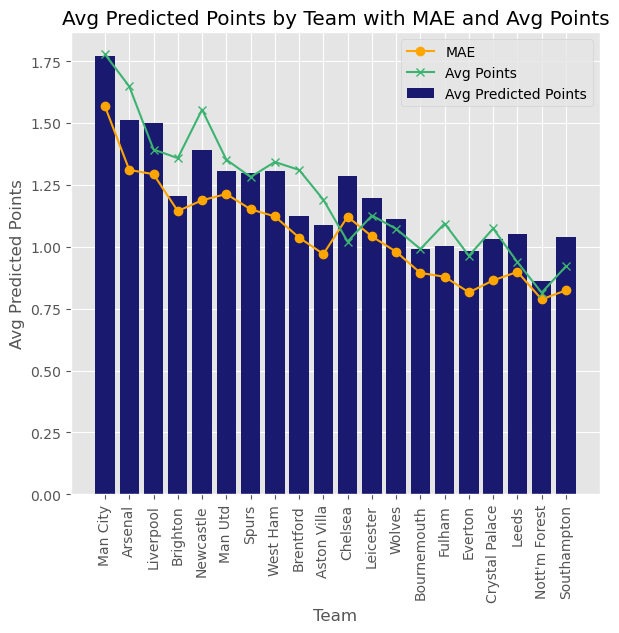

In [80]:
# Sort by mse and select the top 15 players
teams_by_mse = total_team_pred_evals_with_avgs.sort_values(by='mse', ascending=False)

import matplotlib.style as style
style.use('ggplot')

# Plot 1: Avg Predicted Points by Team with MAE and Avg Points
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.bar(teams_by_mse['name'], teams_by_mse['avg_pred'], color='midnightblue')
plt.plot(teams_by_mse['name'], teams_by_mse['mae'], color='orange', marker='o')
plt.plot(teams_by_mse['name'], teams_by_mse['avg_points'], color='mediumseagreen', marker='x')
plt.xlabel('Team')
plt.ylabel('Avg Predicted Points')
plt.title('Avg Predicted Points by Team with MAE and Avg Points')
plt.xticks(rotation=90)
plt.legend(['MAE', 'Avg Points','Avg Predicted Points'])

### Prediction evaluation at the position level

In [81]:
# Look at indexes and predictions for all teams
position_indexes = {}
for i in list(X_test['position'].unique()):
    position_indexes.update({i:X_test.index[X_test['position'] == i].tolist()})

In [89]:
# Calculate and store MSE and MAE for all players in test

mse_dict = {}
mae_dict = {}
position = {}
avg_pred = {}
avg_points = {}

for name, indexes in position_indexes.items():
    mse = mean_squared_error(Y_test.iloc[indexes], Y_test_pred[indexes])
    mae = mean_absolute_error(Y_test.iloc[indexes], Y_test_pred[indexes])
    mse_dict.update({name:mse})
    mae_dict.update({name:mae})
    avg_pred.update({name:np.average(Y_test_pred[indexes])})
    avg_points.update({name:np.average(Y_test.iloc[indexes])})

# Convert dictionaries to dataframes
df1 = pd.DataFrame(list(mse_dict.items()), columns=['position', 'mse'])
df2 = pd.DataFrame(list(mae_dict.items()), columns=['position', 'mae'])
df3 = pd.DataFrame(list(avg_pred.items()), columns=['position', 'avg_pred'])
df4 = pd.DataFrame(list(avg_points.items()), columns=['position', 'avg_points'])

# Merge the two dataframes on the 'name' column
total_pos_pred_evals = pd.merge(df1, df2, on='position')
total_pos_pred_evals_with_avg = pd.merge(total_pos_pred_evals, df3, on='position')
total_pos_pred_evals_with_avgs = pd.merge(total_pos_pred_evals_with_avg, df4, on='position')  

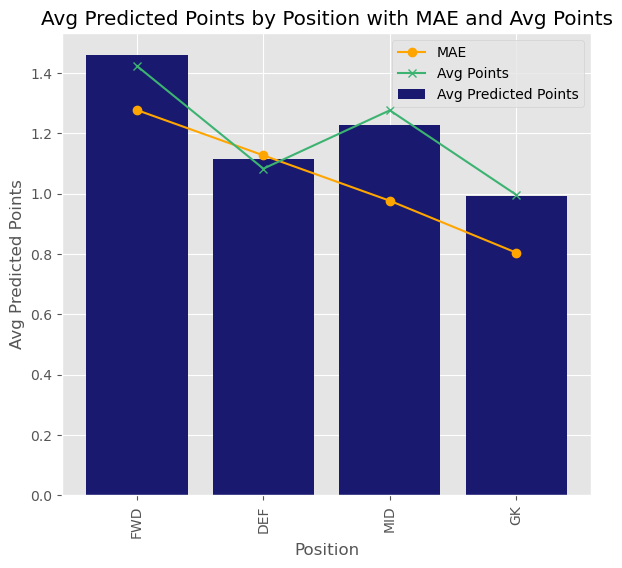

In [94]:
# Sort by mse and select the top 15 players
pos_by_mse = total_pos_pred_evals_with_avgs.sort_values(by='mse', ascending=False)

import matplotlib.style as style
style.use('ggplot')

# Plot 1: Avg Predicted Points by Team with MAE and Avg Points
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.bar(pos_by_mse['position'], pos_by_mse['avg_pred'], color='midnightblue')
plt.plot(pos_by_mse['position'], pos_by_mse['mae'], color='orange', marker='o')
plt.plot(pos_by_mse['position'], pos_by_mse['avg_points'], color='mediumseagreen', marker='x')
plt.xlabel('Position')
plt.ylabel('Avg Predicted Points')
plt.title('Avg Predicted Points by Position with MAE and Avg Points')
plt.xticks(rotation=90)
plt.legend(['MAE', 'Avg Points','Avg Predicted Points'])

### Prediction evaluation at the gameweek level

In [118]:
# Look at indexes and predictions for all gameweeks
gw_indexes = {}
for i in list(X_test['GW'].unique()):
    gw_indexes.update({i:X_test.index[X_test['GW'] == i].tolist()})

In [123]:
# Calculate and store MSE and MAE for all players in test

mse_dict = {}
mae_dict = {}
position = {}
avg_pred = {}
avg_points = {}

for name, indexes in gw_indexes.items():
    mse = mean_squared_error(Y_test.iloc[indexes], Y_test_pred[indexes])
    mae = mean_absolute_error(Y_test.iloc[indexes], Y_test_pred[indexes])
    mse_dict.update({name:mse})
    mae_dict.update({name:mae})
    avg_pred.update({name:np.average(Y_test_pred[indexes])})
    avg_points.update({name:np.average(Y_test.iloc[indexes])})

# Convert dictionaries to dataframes
df1 = pd.DataFrame(list(mse_dict.items()), columns=['gw', 'mse'])
df2 = pd.DataFrame(list(mae_dict.items()), columns=['gw', 'mae'])
df3 = pd.DataFrame(list(avg_pred.items()), columns=['gw', 'avg_pred'])
df4 = pd.DataFrame(list(avg_points.items()), columns=['gw', 'avg_points'])

# Merge the two dataframes on the 'name' column
total_gw_pred_evals = pd.merge(df1, df2, on='gw')
total_gw_pred_evals_with_avg = pd.merge(total_gw_pred_evals, df3, on='gw')
total_gw_pred_evals_with_avgs = pd.merge(total_gw_pred_evals_with_avg, df4, on='gw')  

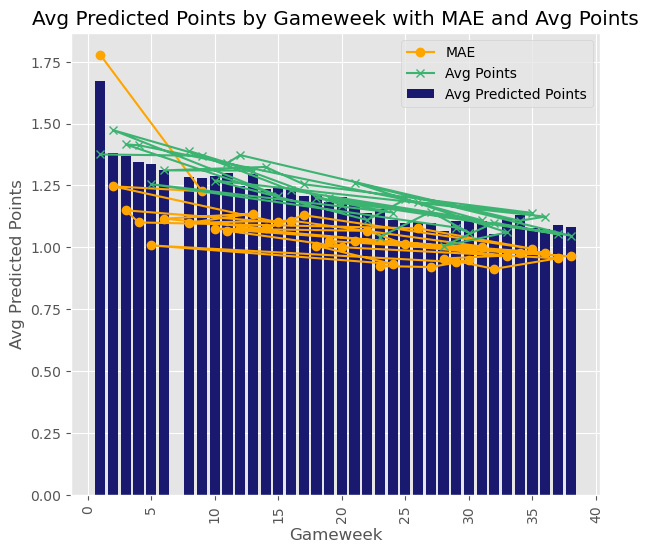

In [124]:
# Sort by mse and select the top 15 players
gw_by_mse = total_gw_pred_evals_with_avgs.sort_values(by='mse', ascending=False)

import matplotlib.style as style
style.use('ggplot')

# Plot 1: Avg Predicted Points by Team with MAE and Avg Points
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.bar(gw_by_mse['gw'], gw_by_mse['avg_pred'], color='midnightblue')
plt.plot(gw_by_mse['gw'], gw_by_mse['mae'], color='orange', marker='o')
plt.plot(gw_by_mse['gw'], gw_by_mse['avg_points'], color='mediumseagreen', marker='x')
plt.xlabel('Gameweek')
plt.ylabel('Avg Predicted Points')
plt.title('Avg Predicted Points by Gameweek with MAE and Avg Points')
plt.xticks(rotation=90)
plt.legend(['MAE', 'Avg Points','Avg Predicted Points'])

# Case Study - Look at Two Teams (Manchester City and Brighton) at the position & player level

In [116]:
# Predict on Man City data (highest scoring team)
man_city_pred = rf.predict(df_man_city_x_encoded)

# Calculate Test MSE & MAE
mse_man_city = mean_squared_error(df_man_city_y, man_city_pred)
mae_man_city = mean_absolute_error(df_man_city_y, man_city_pred)

print(f'Man City MSE: %.3f' % mse_man_city)
print(f'Man City MAE: %.3f' % mae_man_city)

Man City MSE: 7.149
Man City MAE: 1.562


Note how the MSE is significantly higher for Man City, a team which generally has higher performances. However, despite Brighton's surprising returns (comparitive to pundit predictions), they do not seem to have the issue of a significant difference in predictions vs. actuals (compared with overall predictions).

In [117]:
# Predict on Brighton data (most surprising team)
brighton_pred = rf.predict(df_brighton_x_encoded)

# Calculate Test MSE & MAE
mse_brighton = mean_squared_error(df_brighton_y, brighton_pred)
mae_brighton = mean_absolute_error(df_brighton_y, brighton_pred)

print(f'Brighton MSE: %.3f' % mse_brighton)
print(f'Brighton MAE: %.3f' % mae_brighton)

Brighton MSE: 4.849
Brighton MAE: 1.140


In [143]:
# Look at indexes and predictions for all players in both teams
man_city_player_indexes = {}
brighton_player_indexes = {}
for i in list(df_man_city_x['player_name'].unique()):
    man_city_player_indexes.update({i:df_man_city_x.index[df_man_city_x['player_name'] == i].tolist()})
for i in list(df_brighton_x['player_name'].unique()):
    brighton_player_indexes.update({i:df_brighton_x.index[df_brighton_x['player_name'] == i].tolist()})

In [144]:
# Look at MSE and MAE for top scoring player in league

# Calculate Haaland MSE & MAE
mse_erling_haaland = mean_squared_error(df_man_city_y[man_city_player_indexes['Erling Haaland']], man_city_pred[man_city_player_indexes['Erling Haaland']])
mae_erling_haaland = mean_absolute_error(df_man_city_y[man_city_player_indexes['Erling Haaland']], man_city_pred[man_city_player_indexes['Erling Haaland']])

print(f'Haaland MSE: %.3f' % mse_erling_haaland)
print(f'Haaland MAE: %.3f' % mae_erling_haaland)

Haaland MSE: 33.615
Haaland MAE: 4.350


In [169]:
# Calculate and store MSE and MAE for all players in both teams in dataframes

mse_dict = {}
mae_dict = {}
position = {}
avg_pred = {}
avg_points = {}

for name, indexes in man_city_player_indexes.items():
    mse = mean_squared_error(df_man_city_y[indexes], man_city_pred[indexes])
    mae = mean_absolute_error(df_man_city_y[indexes], man_city_pred[indexes])
    mse_dict.update({name:mse})
    mae_dict.update({name:mae})
    avg_pred.update({name:np.average(man_city_pred[indexes])})
    avg_points.update({name:np.average(df_man_city_y[indexes])})
    position.update({name:df_man_city_x['position'][indexes].unique()[0]})  

for name, indexes in brighton_player_indexes.items():
    mse = mean_squared_error(df_brighton_y[indexes], brighton_pred[indexes])
    mae = mean_absolute_error(df_brighton_y[indexes], brighton_pred[indexes])
    mse_dict.update({name:mse})
    mae_dict.update({name:mae})
    avg_pred.update({name:np.average(brighton_pred[indexes])})
    avg_points.update({name:np.average(df_brighton_y[indexes])})
    position.update({name:df_brighton_x['position'][indexes].unique()[0]})  

# Convert dictionaries to dataframes
df1 = pd.DataFrame(list(mse_dict.items()), columns=['name', 'mse'])
df2 = pd.DataFrame(list(mae_dict.items()), columns=['name', 'mae'])
df3 = pd.DataFrame(list(avg_pred.items()), columns=['name', 'avg_pred'])
df4 = pd.DataFrame(list(avg_points.items()), columns=['name', 'avg_points'])
df5 = pd.DataFrame(list(position.items()), columns=['name', 'position'])

# Merge the two dataframes on the 'name' column
team_pred_evals = pd.merge(df1, df2, on='name')
team_pred_evals_with_avg = pd.merge(team_pred_evals, df3, on='name')
team_pred_evals_with_avgs = pd.merge(team_pred_evals_with_avg, df4, on='name')  
team_pred_evals_with_avgs_and_pos = pd.merge(team_pred_evals_with_avgs, df5, on='name')    

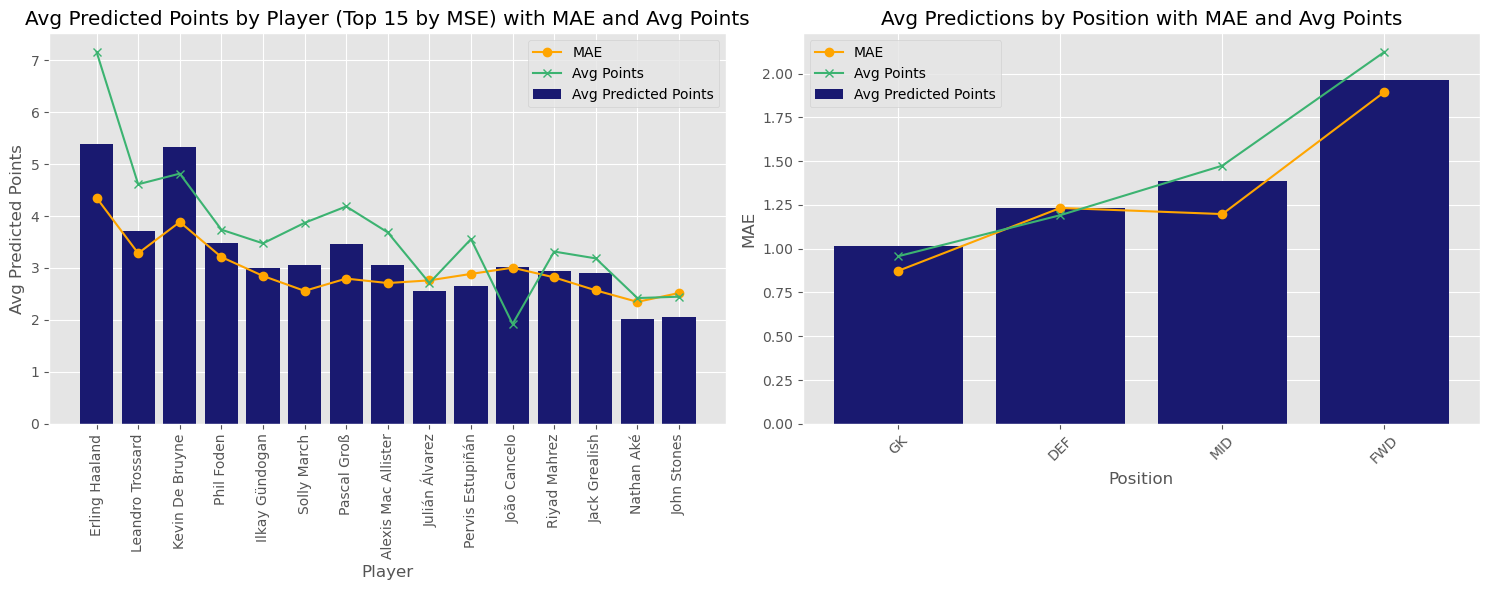

In [183]:
# Sort by mse and select the top 15 players
top_15_mse = team_pred_evals_with_avgs_and_pos.sort_values(by='mse', ascending=False).head(15)

import matplotlib.style as style
style.use('ggplot')

# Plot 1: MAE by player for the top 15 players by MSE
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.bar(top_15_mse['name'], top_15_mse['avg_pred'], color='midnightblue')
plt.plot(top_15_mse['name'], top_15_mse['mae'], color='orange', marker='o')
plt.plot(top_15_mse['name'], top_15_mse['avg_points'], color='mediumseagreen', marker='x')
plt.xlabel('Player')
plt.ylabel('Avg Predicted Points')
plt.title('Avg Predicted Points by Player (Top 15 by MSE) with MAE and Avg Points')
plt.xticks(rotation=90)
plt.legend(['MAE', 'Avg Points','Avg Predicted Points'])

# Plot 2: MAE by position
plt.subplot(1, 2, 2)
position_grouped = team_pred_evals_with_avgs_and_pos.groupby('position').mean('text')
position_grouped_sorted = position_grouped.sort_values(by='avg_pred')
plt.bar(position_grouped_sorted.index, position_grouped_sorted['avg_pred'], color='midnightblue')
plt.plot(position_grouped_sorted.index, position_grouped_sorted['mae'], color='orange', marker='o')
plt.plot(position_grouped_sorted.index, position_grouped_sorted['avg_points'], color='mediumseagreen', marker='x')
plt.xlabel('Position')
plt.ylabel('MAE')
plt.title('Avg Predictions by Position with MAE and Avg Points')
plt.xticks(rotation=45)
plt.legend(['MAE', 'Avg Points','Avg Predicted Points'])

plt.tight_layout()
plt.show()

# Making a Baseline for comparison

In [112]:
# Setting up necessary functions

# Making a vector of predictions as long as the actuals
def pred_vect(true_values, prediction=2):
    predictions = []
    count = 0
    pred = prediction # Can pass baseline or 2
    while count < len(true_values):
        predictions.append(pred)
        count += 1
        
    return predictions

In [129]:
# Creating a baseline with the average value of total points in training set
baseline = Y_train['total_points'].mean()
print(f'The baseline prediction for a player per gameweek is {round(baseline,3)} points per gameweek.')

The baseline prediction for a player per gameweek is 1.359 points per gameweek.


In [115]:
true = np.array(Y_test['total_points'])
pred = np.array(pred_vect(Y_test['total_points'],1))

#print(f'RMSE is {round(RMSE(true, pred),3)}')
print(f'MSE is {round(mean_squared_error(true, pred),3)}')

MSE is 5.586


Comparing the MSE above to that from our Test Random Forest Model (3.85)-- we see that our Test MSE from the Random Forest Tuned model far outperforms the Baseline performance of predicting the mean value from the training seasons.